In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#-*- coding: utf-8 -*-

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [0]:
# 이미지 저장 폴더 생성 
import os
if not os.path.exists("./gan_images"):
    os.makedirs("./gan_images")

# seed 설정
np.random.seed(3)
tf.random.set_seed(3)

#### GAN(Generative Adversarial Networks)
- 위조지폐범과 경찰. 진짜 지폐와 똑같은 위조지폐를 만들기 위해 애쓰는 위조지폐범과 이를 가려내기 위해 노력하는 겨알 사이의 경합이 결국 더 정교한 위조지폐를 만들어 냄.
- 이때, 위조지폐범은 Generator, 경찰은 Discriminator

**DCGAN(Deep Convolutional GAN)**
- 생성자가 가짜 이미지를 만들 때, CNN을 사용함.
- optimizing, compiling 없음.
- pooling 없고 padding 있음. 입출력 크기를 똑같이 맞추기 위함.
- **Batch Normalization**으로 입력 데이터의 평균이 0, 분산이 1이 되도록 재배치하여 다음층으로 입력될 값 일정하게 재배치함.
- Generator의 activation 함수는 ReLU(), Discriminator로 넘겨주기 직전에는 tanh(). tanh() 함수를 써 출력값을 -1~1 사이로 맞춤.

##### Generator

In [0]:
#생성자 모델
generator = Sequential()

# input_dim=100: 100차원 랜덤 벡터 준비해 집어넣음.
# 7*7: UpSampling2D()로 가로 세로 크기 두 배로 늘려줌. UpSampling2D() layer가 두 개니까 7*2*2 = 28 (원래 28*28 픽셀과 맞음)
# --> 이렇게 작은 크기의 이미지를 점점 늘려가면서 convolutional layer 를 지나치게 하는 것이 DCGAN의 특징
# LeakyReLU(): x 값 음수면 무조건 0이 되어 뉴런이 일찍 소실되는 단점 보완하기 위해 0 이하에서도 작은 값 갖게 만듦.

generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2))) 
generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 128))) # Conv2D() input_shape 부분에 들어갈 형태로 
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size=3, padding='same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))


##### Discriminator
- 판별자는 진짜인지 가짜인지 판별만 해주는 것. 
- 판별자가 얻은 가중치는 판별자 자신이 학습하는 데 쓰이는 게 아니라 생성자로 넘겨주어 생성자가 업데이트된 이미지를 만들도록 해야 함.
- 따라서 판별자를 만들 때는 가중치를 저장하는 학습 기능을 꺼주어야 함.
- 생성자에서는 출력 수를 28로 맞춰야 하기 때문에 UpSampling으로 가로, 세로 수를 늘려줬지만 판별자는 진짜, 가짜만 구분하면 되기 때문에 그럴 필요 없음.

In [0]:
# 판별자 모델
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid')) # sigmoid()
discriminator.compile(loss='binary_crossentropy', optimizer='adam') # 1 or 0
discriminator.trainable = False # 판별자 자신이 학습되지 않게끔 학습 기능 꺼줌

##### GAN 실행
- 생성자에서 나온 출력을 판별자에 넣어 진위 여부 판별하게 만듦.
- 판별자가 D(G(input))과 D(x)를 잘 구별하지 못하게 되어 정확도가 0.5에 가까워질 때 학습 종료.

In [8]:
# 생성자와 판별자 모델을 연결시키는 gan 모델
ginput = Input(shape=(100,))
dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 28, 28, 1)         734209    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 212865    
Total params: 947,074
Trainable params: 721,537
Non-trainable params: 225,537
_________________________________________________________________


11493376/11490434 [==============================] - 0s 0us/step
epoch:0  d_loss:0.7024  g_loss:0.6955
epoch:1  d_loss:0.4781  g_loss:0.3400
epoch:2  d_loss:0.5478  g_loss:0.1111
epoch:3  d_loss:0.5973  g_loss:0.0882
epoch:4  d_loss:0.5227  g_loss:0.1917
epoch:5  d_loss:0.4792  g_loss:0.4532
epoch:6  d_loss:0.4508  g_loss:0.7346
epoch:7  d_loss:0.4682  g_loss:0.9439
epoch:8  d_loss:0.4673  g_loss:0.9864
epoch:9  d_loss:0.4680  g_loss:1.0045
epoch:10  d_loss:0.4508  g_loss:0.9299
epoch:11  d_loss:0.4449  g_loss:0.9591
epoch:12  d_loss:0.5865  g_loss:0.9995
epoch:13  d_loss:0.5234  g_loss:1.1978
epoch:14  d_loss:0.6457  g_loss:1.1039
epoch:15  d_loss:0.6037  g_loss:1.0159
epoch:16  d_loss:0.5184  g_loss:0.7982
epoch:17  d_loss:0.4854  g_loss:0.6222
epoch:18  d_loss:0.4219  g_loss:0.4792
epoch:19  d_loss:0.3844  g_loss:0.3740
epoch:20  d_loss:0.3908  g_loss:0.4192
epoch:21  d_loss:0.4065  g_loss:0.4607
epoch:22  d_loss:0.3731  g_loss:0.4172
epoch:23  d_loss:0.2872  g_loss:0.4669
epoch:24 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


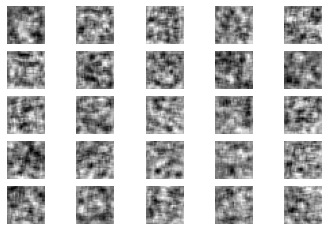

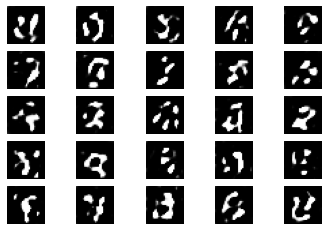

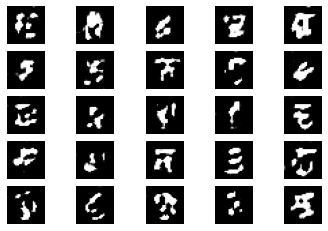

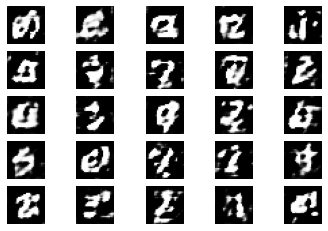

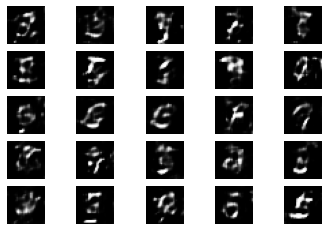

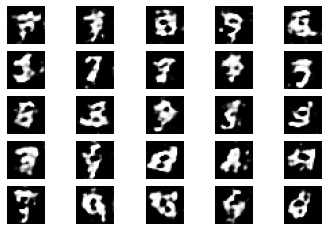

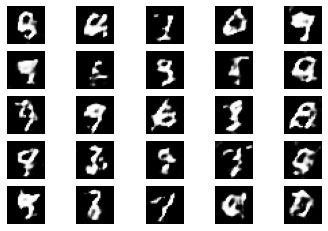

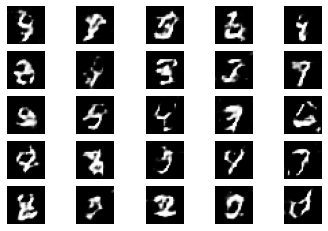

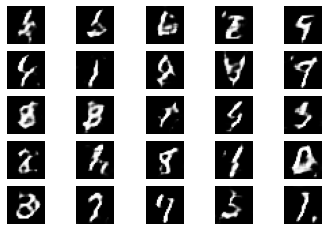

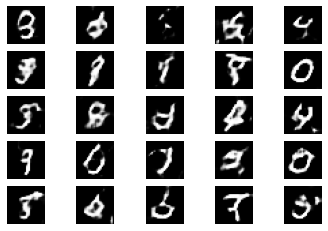

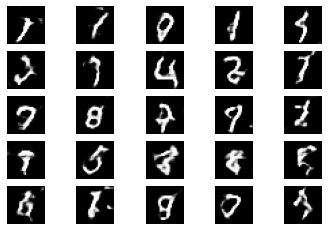

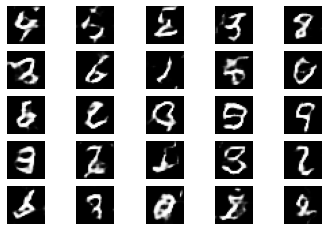

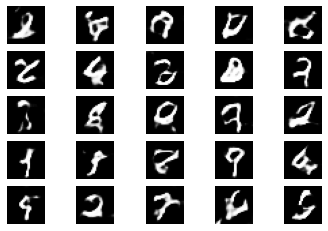

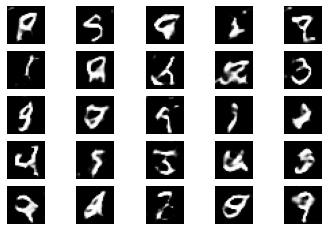

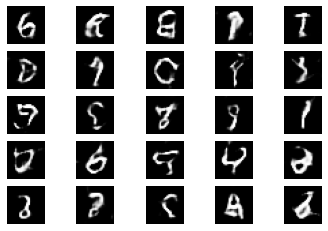

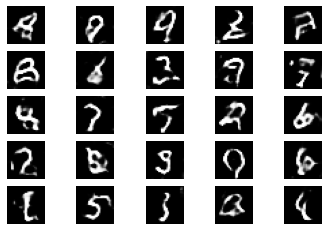

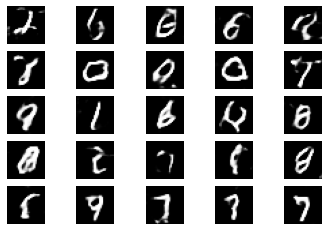

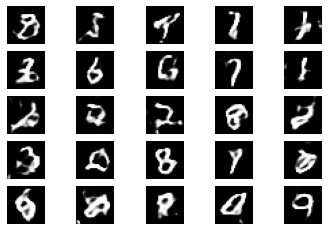

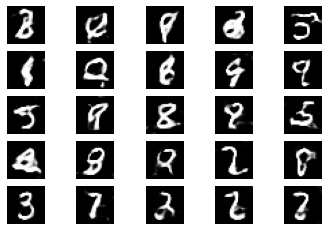

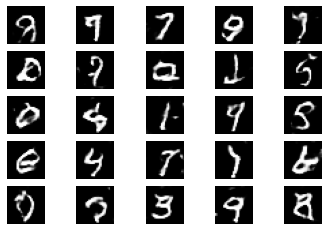

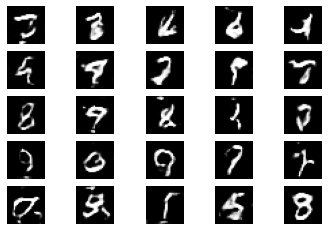

In [9]:
# 신경망을 실행 함수
def gan_train(epoch, batch_size, saving_interval):

    # MNIST 데이터
    (X_train, _), (_, _) = mnist.load_data()  # MNIST를 다시 이용. 이미지만 사용할 것이기 때문에 X_train만
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') # 전처리. reshape, float으로 변환
    X_train = (X_train - 127.5) / 127.5  # 픽셀값은 0에서 255사이의 값. 
    # 이전에 255로 나누어 줄때는 이를 0~1사이의 값으로 바꾸었던 것인데, 
    # 여기서는 -1에서 1사이의 값으로 바꾸기 위해 127.5를 빼준 뒤 127.5로 나눔.

    # batch_size: 한 번에 몇 개 실제 이미지와 몇 개 가상 이미지를 판별자에 넣을지 결정
    # 실제 이미지니까 모두 참(1)이라는 label
    true = np.ones((batch_size, 1))

    # 가상 이미지를 가짜(0) label을 붙임.
    # 학습이 반복될수록 가짜라는 label 붙인 이미지들에 대한 예측 결과가 거짓으로 나올 것.
    fake = np.zeros((batch_size, 1))

    for i in range(epoch):
          # 실제 데이터를 판별자에 입력하는 부분
          # 0 ~ X_train.shape[0]-1 중 batch_size만큼의 수 랜덤하게 선택
          idx = np.random.randint(0, X_train.shape[0], batch_size)
          # 해당 인덱스로 이미지 불러옴
          imgs = X_train[idx]
          # train_on_batch(): x, y 받아서 딱 한 번 학습 실시해 모델 업데이트
          d_loss_real = discriminator.train_on_batch(imgs, true)

          # 가상 이미지를 판별자에 입력하는 부분
          noise = np.random.normal(0, 1, (batch_size, 100)) # normal distribution. batch_size만큼 100 rows 뽑음.
          gen_imgs = generator.predict(noise)
          d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

          # 판별자와 생성자의 오차를 계산
          # 판별자 오차: 각 실제 이미지 넣었을 때의 loss랑 가상 이미지 넣었을 때의 loss 평균
          d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
          # 생성자 오차: gan 모델 이용
          g_loss = gan.train_on_batch(noise, true)

          print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)

          # 이부분은 중간 과정을 이미지로 저장해 주는 부분 gan_images 폴더에 저장
          if i % saving_interval == 0:
              #r, c = 5, 5
              noise = np.random.normal(0, 1, (25, 100))
              gen_imgs = generator.predict(noise)

              # Rescale images 0 - 1
              gen_imgs = 0.5 * gen_imgs + 0.5

              fig, axs = plt.subplots(5, 5)
              count = 0
              for j in range(5):
                  for k in range(5):
                      axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                      axs[j, k].axis('off')
                      count += 1
              fig.savefig("gan_images/gan_mnist_%d.png" % i)

gan_train(4001, 32, 200)  #4000번 반복되고(+1을 해 주는 것에 주의), 배치 사이즈 32,  200번 마다 결과 저장
